# CNN MNIST Digit Recognizer

In [1]:
import sys
print(sys.executable)
print(sys.version)

import warnings
warnings.filterwarnings("ignore")

c:\Python312\python.exe
3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

from model_cpu.model import SimpleCNN, DROPOUT_RATE

## Model Overview

### 1. Model Architecture (SimpleCNN)

The model is a sequential, "LeNet-style" Convolutional Neural Network consisting of two convolutional blocks followed by a classifier.

**Input:** `1 x 28 x 28` (Batch Size, Channels, Height, Width)

#### Convolutional Block 1
* **Layer 1 (Conv2d):**
    * **Number of Filters:** 32
    * **Kernel Size:** 5x5
    * **Stride:** 1
    * **Padding:** 2 (This padding is chosen to preserve the 28x28 dimensions after the 5x5 convolution).
* **Layer 2 (ReLU):**
    * **Activation Function:** Rectified Linear Unit (`nn.ReLU`).
* **Layer 3 (MaxPool2d):**
    * **Kernel Size:** 2x2
    * **Stride:** 2 (This downsamples the feature map).
* **Output of Block 1:** `32 x 14 x 14`

#### Convolutional Block 2
* **Layer 4 (Conv2d):**
    * **Number of Filters:** 64
    * **Kernel Size:** 5x5
    * **Stride:** 1
    * **Padding:** 2 (Preserves the 14x14 dimensions).
* **Layer 5 (ReLU):**
    * **Activation Function:** `nn.ReLU`.
* **Layer 6 (MaxPool2d):**
    * **Kernel Size:** 2x2
    * **Stride:** 2 (Downsamples the feature map).
* **Output of Block 2:** `64 x 7 x 7`

#### Classifier (Fully Connected Layers)
* **Layer 7 (Flatten):**
    * Converts the 3D feature map (`64 x 7 x 7`) into a 1D vector.
    * **Output Size:** `64 * 7 * 7 = 3136`
* **Layer 8 (Linear):**
    * **Input Features:** 3136
    * **Output Features:** 128
* **Layer 9 (ReLU):**
    * **Activation Function:** `nn.ReLU`.
* **Layer 10 (Dropout):**
    * **Regularization Technique:** Dropout
    * **Dropout Rate:** 0.5 (or 50%). Neurons are randomly zeroed out during training to prevent overfitting.
* **Layer 11 (Linear - Output Layer):**
    * **Input Features:** 128
    * **Output Features:** 10 (one for each digit class, 0-9).
* **Final Output:** `1 x 10` (Raw logits/scores for each class).

---

### 2. Training and Hyperparameters

* **Learning Rate:** `0.001`
* **Number of Epochs:** `10`
* **Batch Size:** `64`
* **Regularization:** `nn.Dropout` with `p=0.5` is the primary technique used.
* **Optimizer:** `Adam` (an adaptive learning rate optimization algorithm).

---

### 3. Other Technical Details

* **Loss Function:** `nn.CrossEntropyLoss`. This is the standard for multi-class classification. It conveniently combines a `LogSoftmax` operation and the Negative Log-Likelihood Loss (`NLLLoss`), so the model's output layer just needs to produce raw scores (logits).
* **Data Preprocessing:**
    1.  `transforms.ToTensor()`: Converts PIL images to PyTorch tensors and scales pixel values from the `[0, 255]` integer range to the `[0.0, 1.0]` float range.
    2.  `transforms.Normalize((0.1307,), (0.3081,))`: Standardizes the tensor data by subtracting the mean (`0.1307`) and dividing by the standard deviation (`0.3081`) of the MNIST dataset. This helps the model train faster and more stably.
* **Data Split Strategy:**
    * **Full Training Set:** 60,000 images from MNIST.
    * **Full Test Set:** 10,000 images from MNIST.
    * **Split:** The 60,000-image training set is split **before training** into:
        * **Training Subset:** 54,000 images (90% of the full set).
        * **Validation Subset:** 6,000 images (10% of the full set).
    * The model is trained on the **Training Subset** and its performance is checked against the **Validation Subset** at the end of each epoch. The final, unbiased performance is reported using the separate **Test Set**.

## Hyperparameters and setup

In [3]:
# --- Hyperparameters and Setup ---
DEVICE = torch.device("cpu")
LEARNING_RATE = 0.001
BATCH_SIZE = 64
NUM_EPOCHS = 10
TRAIN_VAL_SPLIT_RATIO = 0.9 # 90% for training, 10% for validation

## CNN Architecture

In [4]:
# See model_cpu/predict.py

## Load Data and Define DataLoaders

In [5]:
# --- 2. Load Data and Define DataLoaders ---
def get_dataloaders():
    # Standard transforms for MNIST
    # ToTensor() scales images from [0, 255] to [0.0, 1.0]
    # Normalize() standardizes the data. (0.1307,) and (0.3081,) are
    # the pre-calculated mean and std dev of the MNIST dataset.
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Download the full training dataset (60,000 images)
    full_train_dataset = datasets.MNIST(
        root='./data', 
        train=True, 
        transform=transform, 
        download=True
    )
    
    # Download the test dataset (10,000 images)
    test_dataset = datasets.MNIST(
        root='./data', 
        train=False, 
        transform=transform, 
        download=True
    )
    
    # Split the full training dataset into training and validation sets
    train_size = int(len(full_train_dataset) * TRAIN_VAL_SPLIT_RATIO)
    val_size = len(full_train_dataset) - train_size
    
    train_subset, val_subset = random_split(
        full_train_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42) # for reproducible splits
    )
    
    print(f"Total training images: {len(train_subset)}")
    print(f"Total validation images: {len(val_subset)}")
    print(f"Total test images: {len(test_dataset)}")
    
    # Create DataLoaders for each set
    train_loader = DataLoader(
        dataset=train_subset, 
        batch_size=BATCH_SIZE, 
        shuffle=True
    )
    val_loader = DataLoader(
        dataset=val_subset, 
        batch_size=BATCH_SIZE, 
        shuffle=False
    )
    test_loader = DataLoader(
        dataset=test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False
    )
    
    return train_loader, val_loader, test_loader

## Training and Evaluation Loop

In [6]:
print(f"Using device: {DEVICE}")
    
# Get DataLoaders
train_loader, val_loader, test_loader = get_dataloaders()

# Initialize model, loss function, and optimizer
model = SimpleCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss() # Combines LogSoftmax and NLLLoss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# History lists to store metrics
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

Using device: cpu
Total training images: 54000
Total validation images: 6000
Total test images: 10000


In [7]:
print("\n--- Starting Training ---")
total_train_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    # --- NEW: Timer for one epoch ---
    epoch_start_time = time.time()
    
    # --- Training Phase ---
    model.train() # Set model to training mode (enables dropout)
    running_train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to the device
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # --- Forward pass ---
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # --- Backward pass and optimization ---
        optimizer.zero_grad() # Clear old gradients
        loss.backward()       # Calculate new gradients
        optimizer.step()        # Update model parameters
        
        running_train_loss += loss.item()
        
        # --- NEW: Calculate training accuracy ---
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    # Calculate average training loss and accuracy
    avg_train_loss = running_train_loss / len(train_loader)
    avg_train_acc = 100 * train_correct / train_total
    
    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode (disables dropout)
    running_val_loss = 0.0 # <--- NEW
    val_correct = 0
    val_total = 0
    
    with torch.no_grad(): # Disable gradient calculation
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(images)
            
            # --- NEW: Calculate validation loss ---
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()
            
            # Get the class with the highest score
            _, predicted = torch.max(outputs.data, 1)
            
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    # Calculate average validation loss and accuracy
    avg_val_loss = running_val_loss / len(val_loader) # <--- NEW
    avg_val_accuracy = 100 * val_correct / val_total
    
    # --- NEW: Record metrics in history ---
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(avg_train_acc)
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(avg_val_accuracy)
    
    # --- NEW: Calculate epoch duration ---
    epoch_end_time = time.time()
    epoch_duration_s = epoch_end_time - epoch_start_time
    
    # --- UPDATED Print Statement ---
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Train: Loss={avg_train_loss:.4f}, Acc={avg_train_acc:.2f}% | "
          f"Val Loss={avg_val_loss:.4f}, Acc={avg_val_accuracy:.2f}% | "
          f"Duration: {epoch_duration_s:.2f}s")

total_train_end_time = time.time()
total_train_duration_m = (total_train_end_time - total_train_start_time) / 60.0
print(f"Total Training Time: {total_train_duration_m:.2f} minutes")
print("--- Finished Training ---")


--- Starting Training ---
Epoch [1/10] | Train: Loss=0.2134, Acc=93.40% | Val Loss=0.0558, Acc=98.42% | Duration: 44.30s
Epoch [2/10] | Train: Loss=0.0731, Acc=97.84% | Val Loss=0.0535, Acc=98.50% | Duration: 43.84s
Epoch [3/10] | Train: Loss=0.0550, Acc=98.44% | Val Loss=0.0390, Acc=98.85% | Duration: 43.52s
Epoch [4/10] | Train: Loss=0.0435, Acc=98.63% | Val Loss=0.0354, Acc=98.97% | Duration: 44.23s
Epoch [5/10] | Train: Loss=0.0345, Acc=98.97% | Val Loss=0.0350, Acc=99.00% | Duration: 43.23s
Epoch [6/10] | Train: Loss=0.0306, Acc=99.09% | Val Loss=0.0369, Acc=99.00% | Duration: 43.87s
Epoch [7/10] | Train: Loss=0.0281, Acc=99.16% | Val Loss=0.0356, Acc=98.98% | Duration: 43.81s
Epoch [8/10] | Train: Loss=0.0231, Acc=99.27% | Val Loss=0.0319, Acc=99.18% | Duration: 45.15s
Epoch [9/10] | Train: Loss=0.0213, Acc=99.34% | Val Loss=0.0351, Acc=99.07% | Duration: 46.35s
Epoch [10/10] | Train: Loss=0.0178, Acc=99.44% | Val Loss=0.0395, Acc=99.07% | Duration: 45.65s
Total Training Time: 7

## Final Evaluation on Test Set

In [8]:
# --- 4. Final Evaluation on Test Set ---
print("\n--- Evaluating on Test Set ---")
model.eval() # Set model to evaluation mode
correct = 0
total = 0

# --- NEW: Lists to store predictions and labels ---
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # --- NEW: Store predictions and labels ---
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
test_accuracy = 100 * correct / total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


--- Evaluating on Test Set ---
Final Test Accuracy: 99.17%


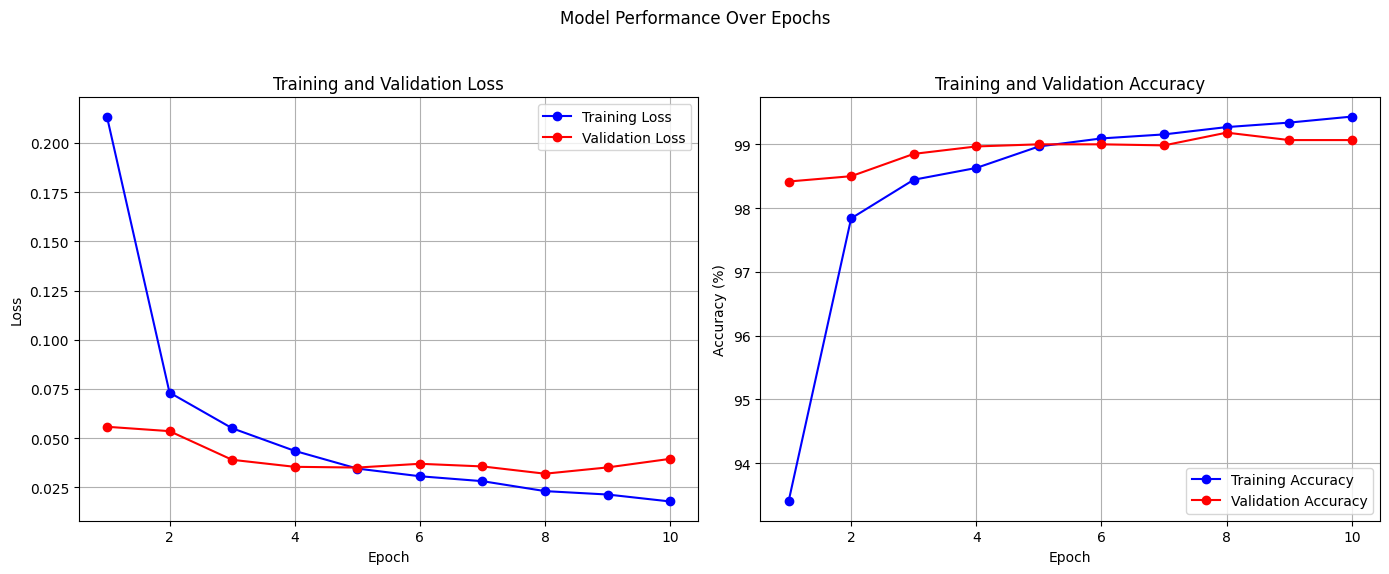

In [9]:
# --- Plotting training and validation metrics ---
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(14, 6))

# Plot 1: Loss vs. Epochs
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss_history, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy vs. Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_history, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc_history, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.suptitle('Model Performance Over Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


--- Generating Confusion Matrix ---


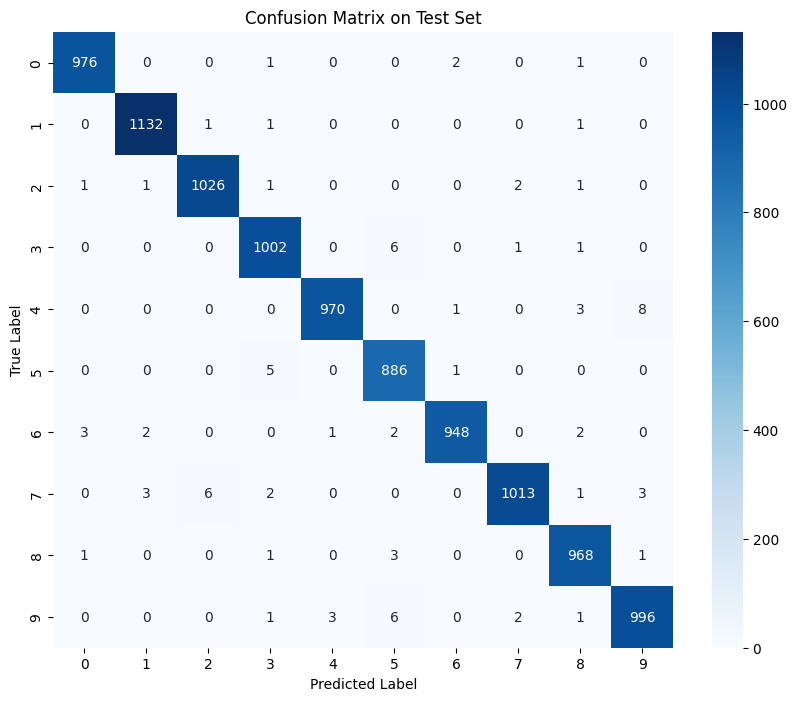

In [10]:
# --- Generating the confusion matrix heatmap ---
print("\n--- Generating Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)

# Get class names (digits 0-9)
class_names = [str(i) for i in range(10)]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names
)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [11]:
# --- Save the trained FP32 model ---
print("\n--- Saving FP32 Model ---")

# Define the directory and file path
SAVE_DIR = "model_cpu/bin"
FP32_MODEL_NAME = "CNN-MNIST-CPU-fp32.pt"
FP32_SAVE_PATH = os.path.join(SAVE_DIR, FP32_MODEL_NAME)

# Create the 'bin' directory if it doesn't exist
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model's state dictionary
try:
    torch.save(model.state_dict(), FP32_SAVE_PATH)
    print(f"FP32 Model saved successfully at: {FP32_SAVE_PATH}")
except Exception as e:
    print(f"Error saving FP32 model: {e}")


--- Saving FP32 Model ---
FP32 Model saved successfully at: model_cpu/bin\CNN-MNIST-CPU-fp32.pt


## Quantization to int8

### Converting from fp32 to int8

In [12]:
# --- 2. Create, Calibrate, and Save INT8 Model ---
print("\n--- Converting FP32 Model to INT8 ---")
# We only need the validation loader for calibration
if 'val_loader' not in locals():
    print("Loading data for calibration...")
    _, val_loader, _ = get_dataloaders()

# 1. Create a new model instance
# IMPORTANT: Must use the *modified* SimpleCNN class
model_to_quantize = SimpleCNN().to(DEVICE)

# 2. Load your saved FP32 weights
print(f"Loading FP32 weights from: {FP32_SAVE_PATH}")

model_to_quantize.load_state_dict(
    torch.load(FP32_SAVE_PATH), 
    strict=False # strict=False is needed for quant/dequant stubs
)
model_to_quantize.eval()

# 3. Fuse modules
print("Fusing modules...")
model_to_quantize.fuse_model()

# 4. Specify quantization configuration
model_to_quantize.qconfig = torch.quantization.get_default_qconfig('fbgemm')
print(f"Using QConfig: {model_to_quantize.qconfig}")

# 5. Prepare the model for calibration
print("Preparing model for calibration...")
torch.quantization.prepare(model_to_quantize, inplace=True)

# 6. Calibrate the model
print("Calibrating model...")
with torch.no_grad():
    for images, _ in val_loader:
        model_to_quantize(images.to(DEVICE))

# 7. Convert to a quantized INT8 model
print("Converting model to INT8...")
torch.quantization.convert(model_to_quantize, inplace=True)

print("--- INT8 Model Created Successfully ---")
int8_model = model_to_quantize


--- Converting FP32 Model to INT8 ---
Loading FP32 weights from: model_cpu/bin\CNN-MNIST-CPU-fp32.pt
Fusing modules...
Using QConfig: QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})
Preparing model for calibration...
Calibrating model...
Converting model to INT8...
--- INT8 Model Created Successfully ---


In [13]:
# --- Save the quantized INT8 model ---
print("\n--- Saving INT8 Model ---")

# Define the directory and file path
SAVE_DIR = "model_cpu/bin" 
INT8_MODEL_NAME = "CNN-MNIST-CPU-int8.pt"
INT8_SAVE_PATH = os.path.join(SAVE_DIR, INT8_MODEL_NAME)

# Directory should already exist, but we use exist_ok=True
os.makedirs(SAVE_DIR, exist_ok=True) 

# Save the quantized model's state dictionary
try:
    torch.save(int8_model.state_dict(), INT8_SAVE_PATH)
    print(f"INT8 Model saved successfully at: {INT8_SAVE_PATH}")
except Exception as e:
    print(f"Error saving INT8 model: {e}")


--- Saving INT8 Model ---
INT8 Model saved successfully at: model_cpu/bin\CNN-MNIST-CPU-int8.pt


### Compare fp32 and int8 models

In [14]:
# --- Helper Functions for Comparison ---
# Helper to print model size
def print_model_size(model, label):
    # Save a temporary file
    torch.save(model.state_dict(), "temp.pt")
    size_mb = os.path.getsize("temp.pt") / (1024 * 1024)
    print(f"Size of {label} model: {size_mb:.2f} MB")
    os.remove("temp.pt")

# Helper to evaluate accuracy
def evaluate_model(model, data_loader, device):
    model.eval()
    model.to(device)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return 100 * correct / total

# Helper to measure inference speed
def measure_inference_speed(model, data_loader, device):
    model.eval()
    model.to(device)
    
    # Use one batch for a test run
    dummy_input = next(iter(data_loader))[0].to(device)
    
    # Warm-up runs
    print("  Running warm-up...")
    for _ in range(10):
        _ = model(dummy_input)
        
    # Measure
    print("  Measuring inference time...")
    start_time = time.time()
    num_batches = 0
    with torch.no_grad():
        for images, _ in data_loader:
            _ = model(images.to(device))
            num_batches += 1
            
    end_time = time.time()
    
    total_time = end_time - start_time
    avg_time_per_batch = (total_time / num_batches) * 1000 # in ms
    return avg_time_per_batch

# Helper to get model size in bytes
def get_model_size(model):
    """Saves model state_dict temporarily to get file size."""
    # Save a temporary file
    torch.save(model.state_dict(), "temp_size_calc.pt")
    size_bytes = os.path.getsize("temp_size_calc.pt")
    os.remove("temp_size_calc.pt")
    return size_bytes

In [15]:
# --- Run the Comparison ---
print("\n--- Comparing FP32 and INT8 Models ---")

# (Ensure test_loader and val_loader are loaded)
if 'test_loader' not in locals():
    print("Loading data for evaluation...")
    _, val_loader, test_loader = get_dataloaders()
    
# --- 1. Load the original FP32 model ---
print("Loading FP32 model from 'bin/CNN-MNIST-CPU-fp32.pt'...")
fp32_model = SimpleCNN().to(DEVICE)
fp32_model.load_state_dict(
    torch.load("bin/CNN-MNIST-CPU-fp32.pt"), 
    strict=False # For quant/dequant stubs
)
fp32_model.eval()

# --- 2. Load the saved INT8 model ---
print("Loading INT8 model from 'bin/CNN-MNIST-CPU-int8.pt'...")
# To load a quantized model, you MUST recreate the same
# fused and quantized structure *before* loading the state_dict.
int8_model_to_load = SimpleCNN().to(DEVICE)
int8_model_to_load.eval()
int8_model_to_load.fuse_model() # Fuse first
int8_model_to_load.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare(int8_model_to_load, inplace=True)
torch.quantization.convert(int8_model_to_load, inplace=True) 

# Now load the saved INT8 state dict
int8_model_to_load.load_state_dict(
    torch.load("bin/CNN-MNIST-CPU-int8.pt")
)
int8_model = int8_model_to_load
print("Models loaded.")

# --- 3. Compare Model Size ---
print("\n--- Model Size Comparison ---")
# (This helper function just prints, it doesn't return)
print_model_size(fp32_model, "FP32")
print_model_size(int8_model, "INT8")

# --- 4. Compare Accuracy ---
print("\n--- Accuracy Comparison (on Test Set) ---")
fp32_accuracy = evaluate_model(fp32_model, test_loader, DEVICE)
print(f"FP32 Model Accuracy: {fp32_accuracy:.2f}%")

int8_accuracy = evaluate_model(int8_model, test_loader, DEVICE)
print(f"INT8 Model Accuracy: {int8_accuracy:.2f}%")

# --- 5. Compare Inference Speed ---
print("\n--- Inference Speed Comparison (on Validation Set) ---")
print("Measuring FP32 model...")
fp32_speed_ms = measure_inference_speed(fp32_model, val_loader, DEVICE)
print(f"-> FP32 Avg. Batch Inference Time: {fp32_speed_ms:.2f} ms")

print("\nMeasuring INT8 model...")
int8_speed_ms = measure_inference_speed(int8_model, val_loader, DEVICE)
print(f"-> INT8 Avg. Batch Inference Time: {int8_speed_ms:.2f} ms")

# --- 6. Summary ---
print("\n--- Summary ---")
# --- FIXED SECTION ---
# Get sizes in bytes using our new helper
fp32_size_bytes = get_model_size(fp32_model)
int8_size_bytes = get_model_size(int8_model)

print(f"Size Reduction: ~{((1 - (int8_size_bytes / fp32_size_bytes)) * 100):.1f}%")
# --- END FIXED SECTION ---
print(f"Speedup: {fp32_speed_ms / int8_speed_ms:.2f}x")
print(f"Accuracy Drop: {fp32_accuracy - int8_accuracy:.2f}%")


--- Comparing FP32 and INT8 Models ---
Loading FP32 model from 'bin/CNN-MNIST-CPU-fp32.pt'...
Loading INT8 model from 'bin/CNN-MNIST-CPU-int8.pt'...
Models loaded.

--- Model Size Comparison ---
Size of FP32 model: 1.74 MB
Size of INT8 model: 0.45 MB

--- Accuracy Comparison (on Test Set) ---
FP32 Model Accuracy: 99.38%
INT8 Model Accuracy: 99.38%

--- Inference Speed Comparison (on Validation Set) ---
Measuring FP32 model...
  Running warm-up...
  Measuring inference time...
-> FP32 Avg. Batch Inference Time: 30.51 ms

Measuring INT8 model...
  Running warm-up...
  Measuring inference time...
-> INT8 Avg. Batch Inference Time: 25.83 ms

--- Summary ---
Size Reduction: ~74.3%
Speedup: 1.18x
Accuracy Drop: 0.00%


Observe the minor speed up. With modern AVX instruction set, we should see __MUCH__ more speed increase right?

Well, `SimpleCNN` is very small and simple.

- **Memory-Bound vs. Compute-Bound**: The model is likely memory-bound, not compute-bound. The bottleneck is the time it takes to move data (images, weights) from RAM to the CPU cache. The actual math (the convolution) is over so quickly that it's not the main bottleneck.
    - The __1.19x__ speed increase is probably from moving 4x less data.

- **Workload is Too Small**: The AVX units on the CPU are like a massive 16-lane highway. This tiny CNN is like sending a few sports cars down it. There's just not enough work given to the CPU to fully saturate those powerful parallel processing lanes. The overhead of "starting the engine" and managing the process takes up more time than the "driving."
    - A __MUCH__ more complex model like a _ResNet-50_ would be compute-bound, and likely see 2x to 4x speedup from saturated AVX units.